<a href="https://colab.research.google.com/github/Ifroza/Machine-Learning_Road-Accident-Severity-Prediction/blob/main/Internship_Project_HealthDataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Generic Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


### **Loading Dataset via webscraping**

In [2]:
import requests
import io
url = "https://archive.ics.uci.edu/static/public/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip"
response = requests.get(url)
# Check if the request was successful (status code 200)
if response.status_code == 200:
    df = pd.read_csv(io.BytesIO(response.content), compression='zip') # Pass response.content to io.BytesIO and specify compression
    # Display the first few rows
    print(df.head())
else:
    print(f"Failed to download file. Status code: {response.status_code}")

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

### **Data Pre-processing**

In [3]:
print(df.shape)

(2111, 17)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [5]:
print(df.describe())

               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.625350  
75% 

In [6]:
print(df.isnull().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [7]:
# Check cardinality of categorical features
num_features = tuple(df.select_dtypes(include=['float64']).columns)
cat_features = tuple(df.select_dtypes(include=['object']).columns)
for col in cat_features:
    print(f'{col} value counts')
    print(df[col].value_counts())
    print()

Gender value counts
Gender
Male      1068
Female    1043
Name: count, dtype: int64

family_history_with_overweight value counts
family_history_with_overweight
yes    1726
no      385
Name: count, dtype: int64

FAVC value counts
FAVC
yes    1866
no      245
Name: count, dtype: int64

CAEC value counts
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64

SMOKE value counts
SMOKE
no     2067
yes      44
Name: count, dtype: int64

SCC value counts
SCC
no     2015
yes      96
Name: count, dtype: int64

CALC value counts
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64

MTRANS value counts
MTRANS
Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64

NObeyesdad value counts
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        

In [8]:
print(df.duplicated().sum())

24


In [9]:
df.drop_duplicates()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


### **Data Visualization**

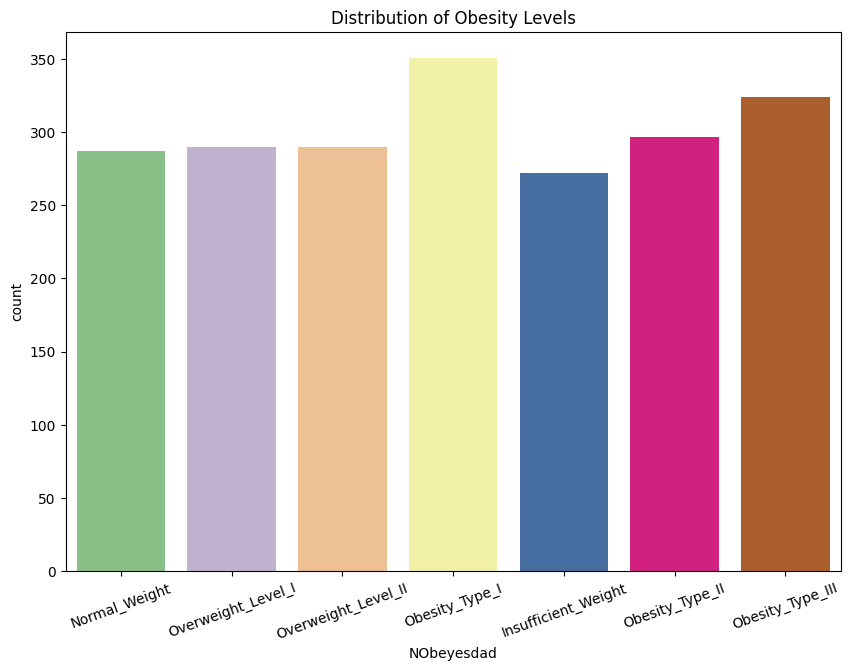

In [10]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='NObeyesdad',palette='Accent')
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=20)
plt.show()

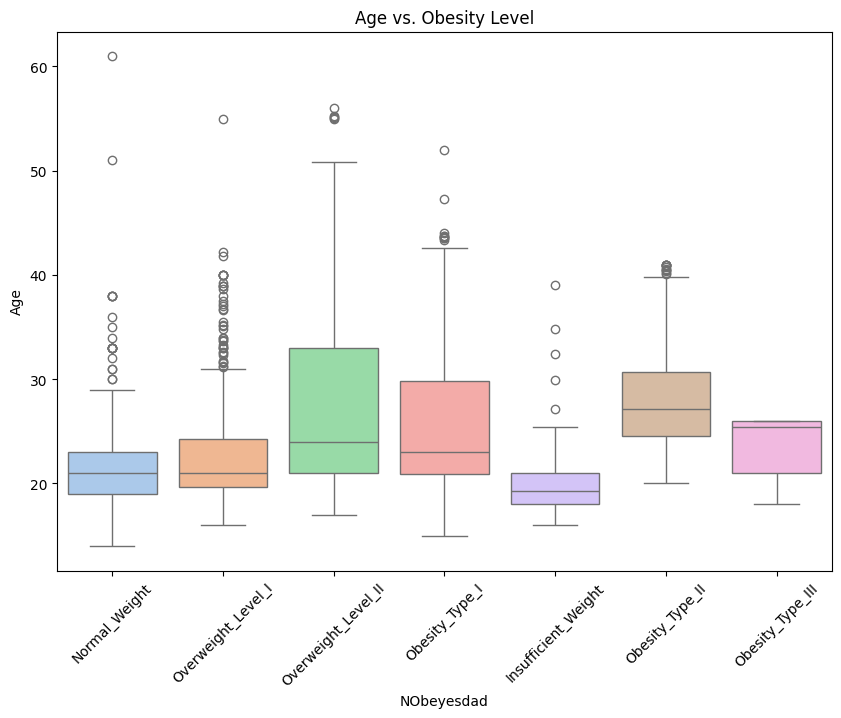

In [11]:
numerical_features = ['Age']
for feature in numerical_features:
    plt.figure(figsize=(10,7))
    sns.boxplot(data=df, x='NObeyesdad', y=feature,palette='pastel')
    plt.title(f'{feature} vs. Obesity Level')
    plt.xticks(rotation=45)
    plt.show()

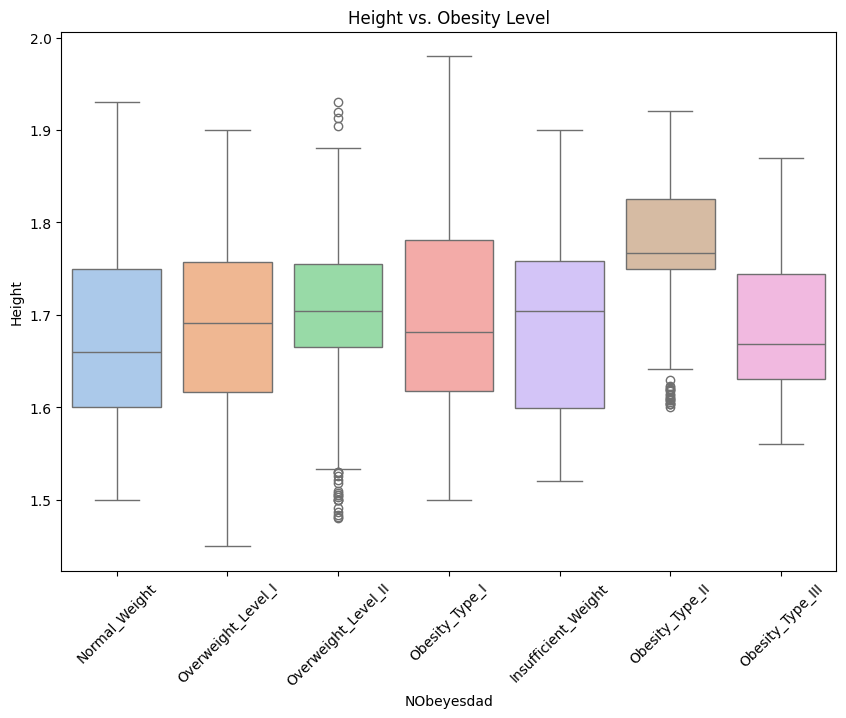

In [12]:
numerical_features = ['Height']
for feature in numerical_features:
    plt.figure(figsize=(10,7))
    sns.boxplot(data=df, x='NObeyesdad', y=feature,palette='pastel')
    plt.title(f'{feature} vs. Obesity Level')
    plt.xticks(rotation=45)
    plt.show()

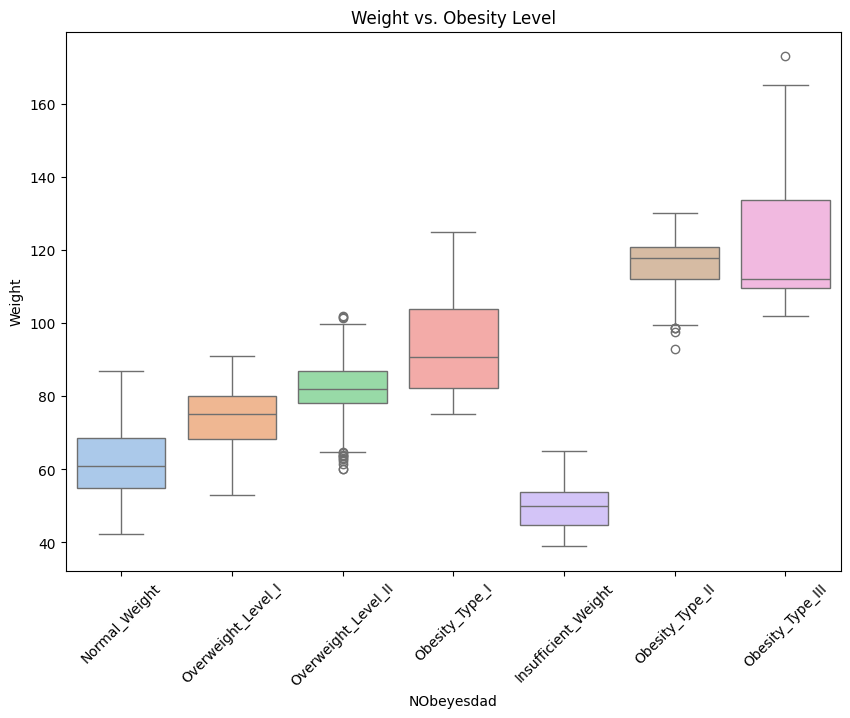

In [13]:
numerical_features = [ 'Weight']
for feature in numerical_features:
    plt.figure(figsize=(10,7))
    sns.boxplot(data=df, x='NObeyesdad', y=feature,palette='pastel')
    plt.title(f'{feature} vs. Obesity Level')
    plt.xticks(rotation=45)
    plt.show()

**Does eating food between meals affect obesity type?**

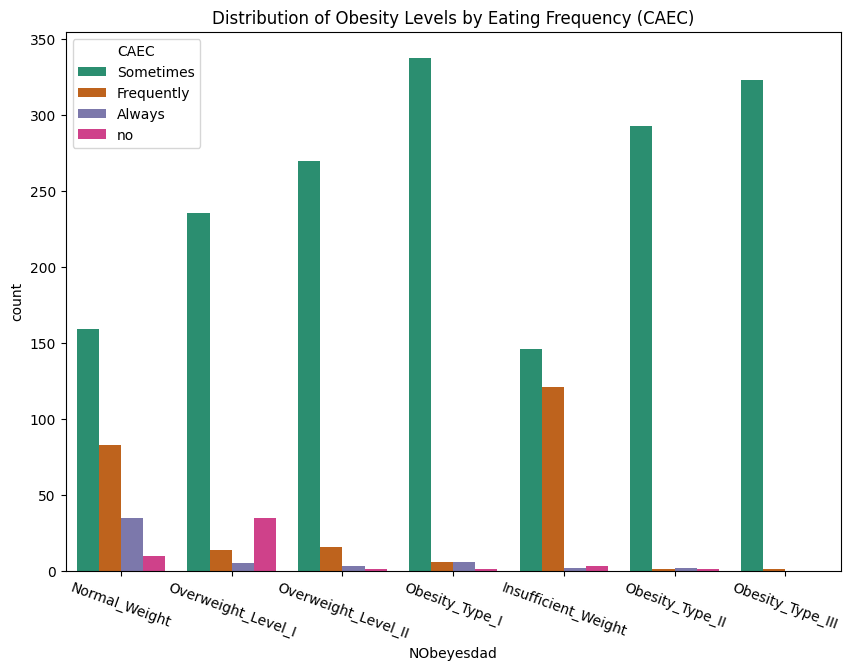

In [14]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x="NObeyesdad", hue="CAEC", palette=sns.color_palette("Dark2"))
plt.xticks(rotation=-20)
plt.title('Distribution of Obesity Levels by Eating Frequency (CAEC)')
plt.show()


**Does family history with overweight affect obesity type?**

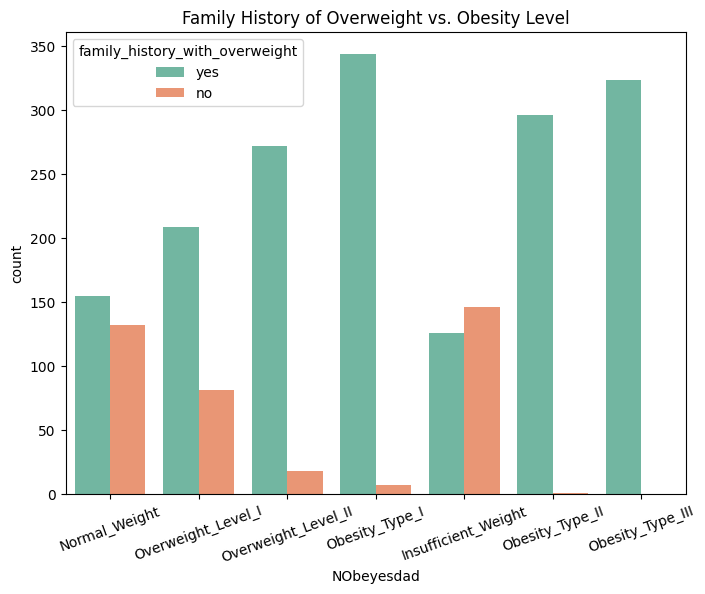

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, hue='family_history_with_overweight', x='NObeyesdad', palette='Set2')
plt.title('Family History of Overweight vs. Obesity Level')
plt.xticks(rotation=20)
plt.show()

###**Feature** **Engineering**

label encoding

In [16]:
lbl=LabelEncoder()
categorical_columns = ['Gender', 'SMOKE', 'family_history_with_overweight','CALC','FAVC','SCC','CAEC','MTRANS','NObeyesdad']
for col in categorical_columns:
    df[col] = lbl.fit_transform(df[col])

correlation heatmap

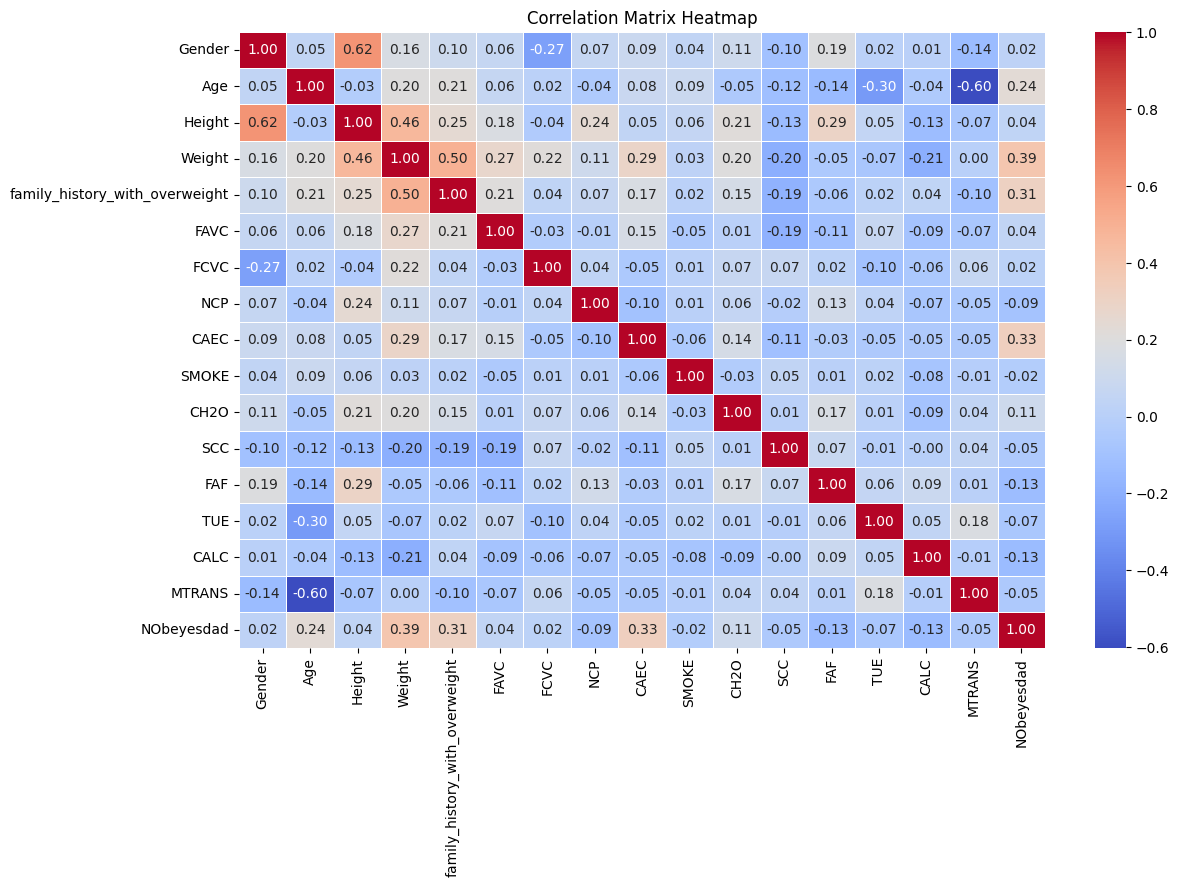

In [17]:
corr_matrix = df.corr()
plt.figure(figsize=(13,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

### **Separating the output label**

In [18]:
y=df['NObeyesdad']
X = df.drop(['NObeyesdad'], axis=1)

### **Train-Test Split & Scaling**

In [19]:
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize scaler
scaler = StandardScaler()

# 3. Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)

# 4. Transform test set using the same scaler
X_test_scaled = scaler.transform(X_test)

### **Model Selection**

In [20]:
#Logistic Regression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90        56
           1       0.82      0.58      0.68        62
           2       0.89      0.82      0.85        78
           3       0.84      1.00      0.91        58
           4       0.97      1.00      0.98        63
           5       0.68      0.68      0.68        56
           6       0.65      0.66      0.65        50

    accuracy                           0.82       423
   macro avg       0.81      0.82      0.81       423
weighted avg       0.82      0.82      0.82       423



In [21]:
#Decision Tree

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        56
           1       0.88      0.85      0.87        62
           2       0.96      0.95      0.95        78
           3       0.96      0.95      0.96        58
           4       1.00      1.00      1.00        63
           5       0.89      0.91      0.90        56
           6       0.98      0.94      0.96        50

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.94      0.94      0.94       423



In [22]:
#Random Forest

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.88      0.90      0.89        62
           2       0.97      0.95      0.96        78
           3       0.97      0.97      0.97        58
           4       1.00      1.00      1.00        63
           5       0.88      0.89      0.88        56
           6       0.94      0.94      0.94        50

    accuracy                           0.95       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.95      0.95       423



**Hyperparameter Tuning**

In [23]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, None] }

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'n_estimators': 150}


**Confusion Matrix**

<Figure size 700x600 with 0 Axes>

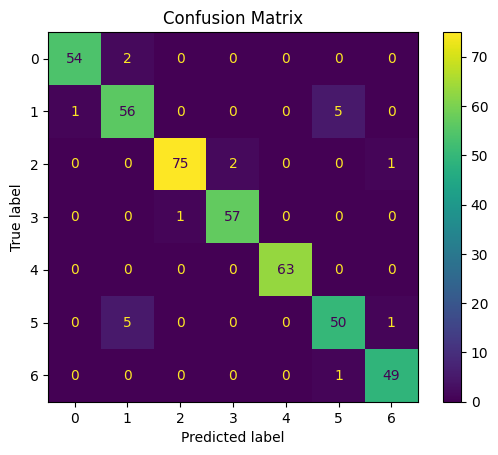

In [24]:
plt.figure(figsize=(7,6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


**Feature Importance**

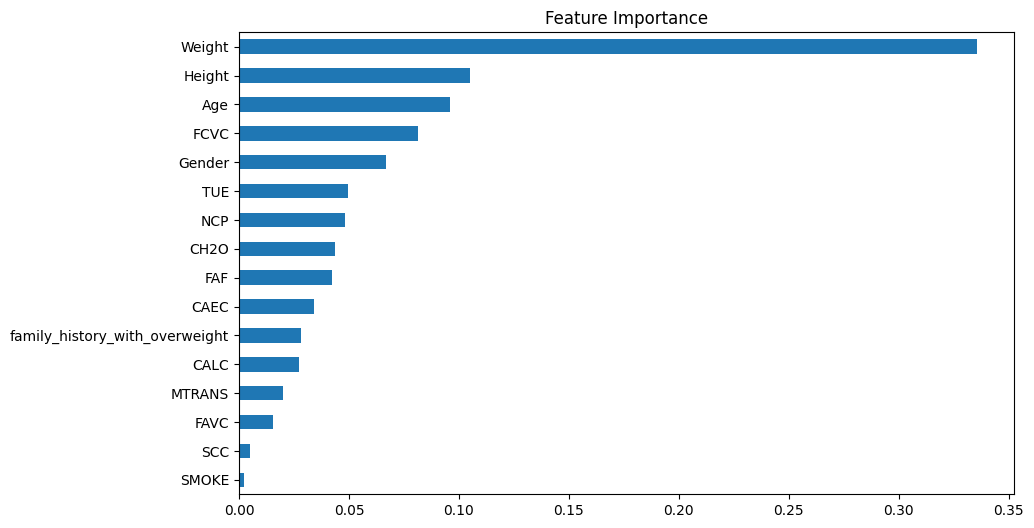

In [25]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(10, 6))
plt.title("Feature Importance")
plt.show()


**ROC-AUC**

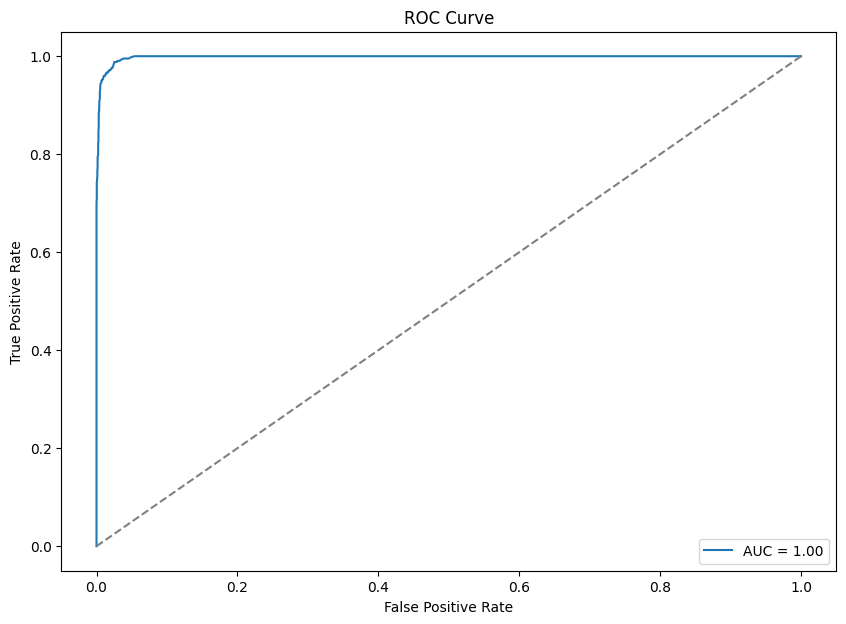

In [26]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba = best_model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
